# How to Explain Black-Box Machine Learning Models
## **Exercise**: _Interpreting an Employment Classifier for North Carolina_
### Workshop for DataCamp — scheduled for July 11th, 2022 10:30 AM EST
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Github](https://github.com/smasis001), [Amazon](https://www.amazon.com/kindle-dbs/entity/author/B08PQ8P9BS?_encoding=UTF8&node=283155&offset=0&pageSize=12&searchAlias=stripbooks&sort=author-sidecar-rank&page=1&langFilter=default#formatSelectorHeader) ) 

## 1) Install Libraries

In [ ]:
!pip install folktables catboost imodels interpret shap

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 76.6 MB 37.1 MB/s            
     |████████████████████████████████| 192 kB 119.4 MB/s            
     |████████████████████████████████| 575 kB 100.8 MB/s            
     |████████████████████████████████| 17.1 MB 102.5 MB/s            
     |████████████████████████████████| 11.7 MB 73.2 MB/s            
     |████████████████████████████████| 62 kB 3.8 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 46 kB 9.6 MB/s             
     |████████████████████████████████| 11.3 MB 8.1 MB/s            
     |████████████████████████████████| 41.6 MB 90.7 MB/s            
     |████████████████████████████████| 15.2 MB 86.6 MB/s            
     |████████████████████████████████| 1.3 MB 106.0 MB/s            
     |████████████████████████████████| 78 kB 12.9 MB/s             
     |████████████████████████████████| 31.2 MB 97.7 MB/s            
     |███████

 It might throw a few minor errors but still install libraries successfully.

## 2) Load Libraries

In [ ]:
import math
import os
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)

#DATA WRANGLING
import numpy as np
import pandas as pd
from folktables import ACSDataSource, ACSEmployment
from sklearn.model_selection import train_test_split

#MODELING
from tqdm.notebook import trange, tqdm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, linear_model, tree, ensemble, neural_network
import catboost as cb
from imodels import FIGSClassifier
from interpret.glassbox import ExplainableBoostingClassifier

#VISUALIZATION & INTERPRETATION
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## 3) Data Understanding & Preparations

### 3.1) Load Dataset

These two lines will grab the Census data for one year and then subset the data for one state.

In [ ]:
data_source = ACSDataSource(survey_year='2017', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["NC"], download=True)

If we take a sample of this dataset we realize it returns hundreds of variables:

In [ ]:
acs_data

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2017000000033,5,1,400,3,37,1011189,12,38,...,17,32,13,14,4,12,18,11,15,17
1,P,2017000000033,5,2,400,3,37,1011189,18,34,...,30,35,21,15,7,24,20,23,19,21
2,P,2017000000033,5,3,400,3,37,1011189,10,17,...,15,23,9,12,4,8,14,9,9,11
3,P,2017000000033,5,4,400,3,37,1011189,11,15,...,15,22,8,12,4,8,14,8,10,10
4,P,2017000000033,5,5,400,3,37,1011189,14,11,...,23,23,13,13,5,12,21,13,11,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101228,P,2017001536792,5,1,1201,3,37,1011189,10,31,...,10,20,10,11,10,1,11,1,10,1
101229,P,2017001536804,5,1,3300,3,37,1011189,12,17,...,22,2,2,22,12,2,20,22,12,13
101230,P,2017001536808,5,1,5001,3,37,1011189,76,19,...,147,6,75,6,74,146,78,144,7,6
101231,P,2017001536830,5,1,3103,3,37,1011189,52,18,...,4,96,100,51,52,4,4,100,52,4


### 3.2) Preprocess Steps

There are a few quick preprocessing steps we will need to do since we are only interested in certain features and individuals at least 16 years old. We will also convert a few categorical variables to binary format and turn our categorical target (`ESR`) into binary as well.

In [ ]:
#Subset and preprocess the variables to only those that matter for employment purposes
employment_df = ACSEmployment._preprocess(acs_data)\
                        [ACSEmployment.features + [ACSEmployment.target]].fillna(0).astype(int)

#Subset to only those over or equal to the age of 16 (of working age without parental permission in the state of NC)
employment_df = employment_df[employment_df.AGEP >= 16]

#Encode several variables that only have two categories as binary
employment_df['DIS'] = np.where(employment_df.DIS == 1, 1, 0)
employment_df['NATIVITY'] = np.where(employment_df.NATIVITY == 1, 1, 0)
employment_df['DEAR'] = np.where(employment_df.DEAR == 1, 1, 0)
employment_df['DEYE'] = np.where(employment_df.DEYE == 1, 1, 0)
employment_df['DREM'] = np.where(employment_df.DREM == 1, 1, 0)

#Encode employment variable status as those that are NOT WORKING as 1 versus those that are WORKING as 0
employment_df['ESR'] = np.where((employment_df['ESR'] != 1) & (employment_df['ESR'] != 4), 1, 0)

Better also rename the columns to make them easier to interpret:

In [ ]:
employment_df = employment_df.rename(columns={'AGEP':'Age', 'SCHL':'Schooling', 'MAR':'Marital Status',\
                                              'RELP':'Relationship', 'DIS':'Disability', 'ESP':'Employment Status',\
                                              'CIT':'Citizen Status', 'MIG':'Mobility Status', 'MIL':'Military Service',\
                                              'ANC':'Ancestry', 'NATIVITY':'Nativity', 'DEAR':'Hearing Difficulty',\
                                              'DEYE':'Vision Difficulty', 'DREM':'Cognitive Difficulty', 'SEX':'Sex',\
                                              'RAC1P':'Race'})

### 3.3) Inspect Dataset

At a glance with `info()`:

In [ ]:
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83517 entries, 0 to 101232
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   83517 non-null  int64
 1   Schooling             83517 non-null  int64
 2   Marital Status        83517 non-null  int64
 3   Relationship          83517 non-null  int64
 4   Disability            83517 non-null  int64
 5   Employment Status     83517 non-null  int64
 6   Citizen Status        83517 non-null  int64
 7   Mobility Status       83517 non-null  int64
 8   Military Service      83517 non-null  int64
 9   Ancestry              83517 non-null  int64
 10  Nativity              83517 non-null  int64
 11  Hearing Difficulty    83517 non-null  int64
 12  Vision Difficulty     83517 non-null  int64
 13  Cognitive Difficulty  83517 non-null  int64
 14  Sex                   83517 non-null  int64
 15  Race                  83517 non-null  int64
 16  ESR

or with just look at the entire dataframe:

In [ ]:
employment_df

,Age,Schooling,Marital Status,Relationship,Disability,Employment Status,Citizen Status,Mobility Status,Military Service,Ancestry,Nativity,Hearing Difficulty,Vision Difficulty,Cognitive Difficulty,Sex,Race,ESR
0,38,16,1,0,0,0,1,1,4,4,1,0,0,0,1,1,0
1,34,16,1,1,1,0,1,1,4,4,1,1,0,0,2,1,0
2,17,14,5,2,0,1,1,1,4,4,1,0,0,0,2,1,0
5,58,18,1,0,0,0,1,1,4,1,1,0,0,0,1,1,0
6,60,16,1,1,0,0,1,1,4,1,1,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101228,31,22,3,17,0,0,1,3,4,1,1,0,0,0,1,1,1
101229,17,14,5,16,0,0,1,1,4,1,1,0,0,0,1,9,1
101230,19,19,5,17,0,0,1,1,4,1,1,0,0,0,1,2,0
101231,18,18,5,17,0,0,1,1,4,2,1,0,0,0,2,2,1


We won't have time to do proper EDA in the session but I'd recommend at least running [`pandas-profiling`](https://github.com/ydataai/pandas-profiling) on it.

In the meanwhile, here's a summarised data dictionary:

- `Age`: ordinal, age
- `Schooling`: ordinal, educational attainment (0: too young, 1: no schooling, 2: preschool,... 24: doctorate)
- `Marital Status`: categorical, marital status (1: married, 2:widowed, 3:divorced, 4:separated, 5:never married or too young)
- `Relationship`: categorical, relationship (0: reference person, 1:spouse, 2:biological child,... 17:noninstitutionalized group quarters population)
- `Disability`: binary, disability (1: with a disability, 0:without)
- `Employment Status`: categorical, employment status of parents (0: n/a, 1:living with two parents & both parents employed,... 8:living with mother & mother not in labor force) 
- `Citizen Status`: categorical, citizen status (1:born in the US, 2: born in US territories, 3:born abroad to US parents, 4:US citizen by naturalization, 5:not a citizen)
- `Mobility Status`: categorical, mobility status from a year ago (1: yes, same house, 2:no, internationally, 3:no, different house in US)
- `Military Service`: categorical, military service (0: n/a, 1:in active duty now, 2:used to be in duty, 3:only for training in reserves, 4:never served)
- `Ancestry`: categorical, ancestry (1: single, 2:multiple, 3:unclassified, 4:not reported,...)
- `Nativity`: binary, nativity (1:native born, 0:foreign born)
- `Hearing Difficulty`: binary, hearing difficulty (1: yes, 0:no)
- `Vision Difficulty`: binary, vision difficulty (1:yes, 0:no)
- `Cognitive Difficulty`: binary, cognitive difficulty (1:yes, 0:no)
- `Sex`: categorical, sex (1: male, 2:female)
- `Race`: categorical, recoded detailed race code (1:white, 2:black, 3:american indian, 4:alaska native,... 9:two or more races)

You can learn for about the FOLKTABLES package and the ACS data source in the [Github repository](https://github.com/zykls/folktables) or in the corresponding academic paper:

> Ding, F., Hardt, M., Miller, J., & Schmidt, L. (2021). Retiring Adult: New Datasets for Fair Machine Learning. [ArXiv, abs/2108.04884](https://arxiv.org/pdf/2108.04884.pdf).

### 3.4) Check Imbalance

Even though we won't do a full EDA, one thing that it's important to note is class balance. Some folks use bar plots but what's important here is what is the percentage of people in the positive class — that is, those that are not working.

In [ ]:
prop_esr = employment_df['ESR'].mean()
print(f"Percentage Not Working:\t{prop_esr:.1%}")

Percentage Not Working:	45.6%


### 3.5) Final Preparation Steps

Define a seed for reproducibility:

In [ ]:
rand = 42
os.environ['PYTHONHASHSEED']=str(rand)
np.random.seed(rand)

Define `X` and `y` and then test/train split them, as well as make lists for our classes (`class_l`) and features (`feature_l`).

In [ ]:
class_l = ['Working','Not Working']

X = employment_df.drop(['ESR'], axis=1)
y = employment_df['ESR']
feature_l = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rand)

## 4) Modeling & Evaluation

### 4.1) Define Models to train

We will quickly train 10 models. 

In [ ]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': make_pipeline(StandardScaler(), 
                                           linear_model.LogisticRegression(C=10,  penalty='l1', solver='liblinear',\
                                                                           random_state=rand, class_weight='balanced'))},  
    
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced',\
                                                              random_state=rand)},

    
        #Interpretable rule-based models
        'figs':{'model': FIGSClassifier(max_rules=11, random_state=rand),\
                'fit_args':{'feature_names':feature_l}},
    
        #Interpretable GAM-based models
        'ebm':{'model': ExplainableBoostingClassifier(random_state=rand, learning_rate=0.03, n_jobs=-1)},
    
        #Ensemble Methods
        'catboost':{'model': cb.CatBoostClassifier(max_depth=3, scale_pos_weight=1.3, random_state=rand,\
                                                   verbose=0)},
    
        #Neural Networks
        'mlp':{'model':make_pipeline(MinMaxScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(8,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

A couple of disclaimers:

- No hyperparameter tuning since I've already predetermined some good hyperparameters. 
- It's highly recommended to evaluate on Stratified K-Fold cross-validation but we won't have time to do that now. In any case, the results won't be too far from the CV averages.

### 4.2) Batch train and evaluate

It should take no more than 90 seconds to iterate across all models `fit`, `predict` and `score` them:

In [ ]:
%%time
for model_name in tqdm(class_models.keys()):
    fitted_model = class_models[model_name]['model']
    if 'fit_args' in class_models[model_name]:
        fitted_model.fit(X_train.values, y_train.values,\
                         **class_models[model_name]['fit_args'])
        y_train_pred = fitted_model.predict(X_train.values)
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
    else:
        fitted_model.fit(X_train, y_train)
        y_train_pred = fitted_model.predict(X_train)
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
    y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['pred_test'] = y_test_pred
    class_models[model_name]['prob_test'] = y_test_prob
    class_models[model_name]['acc_train'] = metrics.accuracy_score(y_train.values, y_train_pred)
    class_models[model_name]['acc_test'] = metrics.accuracy_score(y_test.values, y_test_pred)
    class_models[model_name]['precision'] = metrics.precision_score(y_test.values, y_test_pred)
    class_models[model_name]['recall'] = metrics.recall_score(y_test.values, y_test_pred)
    class_models[model_name]['f1'] = metrics.f1_score(y_test.values, y_test_pred)
    class_models[model_name]['roc-auc'] = metrics.roc_auc_score(y_test.values, y_test_prob)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 33.1 s, sys: 12.5 s, total: 45.6 s
Wall time: 53 s


### 4.3) Compare models
#### _Model selection_?

The following code simply takes the dictionary produced in the previous step and converts it into a dataframe. It also formats it to have the top 4 models for every metric color-coded.

In [ ]:
class_metrics_df = pd.DataFrame.from_dict(class_models, 'index').drop(['model','fit_args','pred_test','prob_test'], axis=1)
class_metrics_df = class_metrics_df*100

class_metrics_df.sort_values(by='f1', ascending=False).style.\
    format(dict(zip(class_metrics_df.columns, ['{:.1f}']*7))).\
    highlight_max()

,acc_train,acc_test,precision,recall,f1,roc-auc
catboost,80.3,79.4,78.0,76.4,77.2,86.8
ebm,79.9,79.3,80.0,72.8,76.2,86.5
figs,78.7,78.6,78.0,73.9,75.9,84.0
mlp,78.6,78.2,78.6,71.8,75.1,85.1
decision_tree,75.8,75.6,76.8,66.7,71.4,80.5
logistic,73.7,73.8,71.9,70.1,71.0,79.7


Usually this is the extent of all model interpretation performed. Solely for model-selection purposes which is like piloting an old-fashioned plane with half a dozen instruments. Indeed, Interpretable ML (or XAI) is like the collection of tools used to "pilot" AI/ML.

![AI Right Now](https://github.com/smasis001/av-2022/blob/main/AI-Right-Now.png?raw=1)

Which plane would you rather pilot (or be a passenger in)? Be honest! Left or right? 

Just as additional instrumentation in planes makes flying safer, additional instrumentation in ML can make predictive modelling fairer, more robust, and overall, more trustworthy.

### 4.4) Error analysis
#### _An introduction_

It makes sense to look further into how misclassification are distributed in order to understand how model error can impact reliability, safety, and fairness. This is a broad topic and there are better tools to perform just this task. I highly recommend Microsoft's open source [Error Analysis tool](https://techcommunity.microsoft.com/t5/ai-machine-learning-blog/responsible-machine-learning-with-error-analysis/ba-p/2141774). We won't use it here but I will provide a quick example of how error distribution can impact outcomes.

Firstly, in order to simplify comparing cohorts we will translate encoded categories into labels so we will create dictionaries that match a code to a label:

In [ ]:
race_dict = {1: 'White', 2: 'Black', 3: 'Other', 4: 'Other', 5: 'Other', 6: 'Asian',\
             7: 'Other', 8: 'Other', 9: 'Other'}
sex_dict = {1: 'Male', 2:'Female'}

Then, the following functions can group the dataframe by a variable and then compute predictive performance metrics for that group alone:

In [ ]:
def metrics_by_group(s):
    accuracy = metrics.accuracy_score(s.y_true, s.y_pred) * 100
    precision = metrics.precision_score(s.y_true, s.y_pred) * 100
    recall = metrics.recall_score(s.y_true, s.y_pred) * 100
    f1 = metrics.f1_score(s.y_true, s.y_pred) * 100
    roc_auc = metrics.roc_auc_score(s.y_true, s.y_prob) * 100
    tn, fp, fn, tp = metrics.confusion_matrix(s.y_true, s.y_pred).ravel()
    fnr = (fn/(tp+fn)) * 100
    fpr = (fp/(tn+fp)) * 100
    support = len(s.y_true)

    return pd.Series((support, accuracy, precision, recall, f1, roc_auc, fnr, fpr),\
                     index=['support', 'accuracy', 'precision', 'recall', 'f1', 'roc-auc', 'fnr', 'fpr'])

def error_breakdown_by_group(mdl_name, group_col, replace_dict, group_name=None):
    mdl = class_models[mdl_name]
    if group_name is None:
        group_name = group_col
    print('Error breakdown for model "%s" and group "%s"' % (mdl_name, group_name))
        
    predict_df = pd.DataFrame({group_name: X_test[group_col].replace(replace_dict).tolist(),\
                              'y_true': y_test.tolist(),
                              'y_pred': mdl['pred_test'],
                              'y_prob': mdl['prob_test']}, index=X_test.index)

    group_metrics_df = predict_df.groupby([group_name]).apply(metrics_by_group)

    html = group_metrics_df.sort_values(by='support', ascending=False).style.\
            format({'support':'{:,.0f}', 'accuracy':'{:.1f}%', 'precision':'{:.1f}%', 'recall':'{:.1f}%',\
                    'f1':'{:.1f}%', 'roc-auc':'{:.1f}%', 'fnr':'{:.1f}%', 'fpr':'{:.1f}%'}).\
            highlight_max(subset=['accuracy','precision','recall','f1','roc-auc']).\
            highlight_min(subset=['fnr','fpr'])
    
    return html

Here we will use this function to compute predictive performance by race:

In [ ]:
error_breakdown_by_group('decision_tree', 'Race', race_dict)

Error breakdown for model "decision_tree" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
Race,,,,,,,,
White,"15,669",77.0%,76.6%,70.2%,73.3%,81.3%,29.8%,17.5%
Black,"3,678",72.1%,79.8%,60.5%,68.8%,80.1%,39.5%,15.9%
Other,"1,004",69.9%,70.9%,50.8%,59.2%,72.8%,49.2%,15.7%
Asian,529,69.0%,68.4%,37.9%,48.8%,68.2%,62.1%,11.1%


As you can see one race tops most metrics, but this distribution varies from model to model.

In [ ]:
error_breakdown_by_group('catboost', 'Race', race_dict)

Error breakdown for model "catboost" and group "Race"


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
Race,,,,,,,,
White,"15,669",79.8%,78.0%,76.6%,77.3%,87.1%,23.4%,17.6%
Black,"3,678",78.9%,80.1%,77.9%,79.0%,86.5%,22.1%,20.1%
Other,"1,004",76.4%,73.3%,70.8%,72.0%,83.8%,29.2%,19.4%
Asian,529,76.2%,70.4%,67.0%,68.7%,81.9%,33.0%,18.0%


We can do the same for sex now:

In [ ]:
error_breakdown_by_group('catboost', 'Sex', sex_dict)

Error breakdown for model "catboost" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
Sex,,,,,,,,
Female,"10,974",76.7%,78.0%,74.5%,76.2%,83.9%,25.5%,21.0%
Male,"9,906",82.3%,78.1%,79.0%,78.5%,89.2%,21.0%,15.4%


In [ ]:
error_breakdown_by_group('mlp', 'Sex', sex_dict)

Error breakdown for model "mlp" and group "Sex"


,support,accuracy,precision,recall,f1,roc-auc,fnr,fpr
Sex,,,,,,,,
Female,"10,974",76.1%,78.6%,71.7%,75.0%,82.8%,28.3%,19.6%
Male,"9,906",80.5%,78.7%,71.9%,75.1%,87.0%,28.1%,13.5%


One group is favored by both models.

There's a whole host of tools used to quantify bias and then mitigate it. I recommend [AI Fairness 360](https://github.com/Trusted-AI/AIF360).

But starting to understand a model starts with the foundation:

![FAT Diagram](https://github.com/smasis001/av-2022/blob/main/FAT_diagram2v2_LI.gif?raw=1)

As you can appreciate in the diagram, transparency is at the bottom so we need to understand the models first and foremost. So, let's...

> # DIG DEEPER!

## 5) Model explanations/interpretations

This section is about learning how the model works or at least an interpretation of how it's arriving to it's predictions.

When looking under the hood some models are priviledged with simple mechanisms. These are typically referred to as **White Box**. On the other hand, **Black Box** models are too complex to make sense us. For the former we can use **model-specific methods** and for the latter mostly **model-agnostic methods** are used.

![White Box, Black Box](https://github.com/smasis001/av-2022/blob/main/WhiteBoxBlackBox.png?raw=1)

### 5.1) Model-specific (using intrinsic parameters)

#### 5.1.1) Logistic Regression

Logistic regression, like all Generalized Linear Models (GLM), has a mathematical formula, where coefficients determine the weight of a feature. When that feature has been standarized as ours has, we can interpret the absolute value of each coefficient as the relative importance of the feature.

In [ ]:
coefs_log = class_models['logistic']['model'].steps[1][1].coef_[0]

pd.DataFrame({'feature':feature_l, 'importance':np.abs(coefs_log)}).sort_values('importance', ascending=False).style.\
                bar(subset=['importance'], color='#4EF', width=100)

,feature,importance
0,Age,0.986192
4,Disability,0.513927
3,Relationship,0.468035
1,Schooling,0.424737
5,Employment Status,0.335305
14,Sex,0.293297
2,Marital Status,0.239696
8,Military Service,0.143503
13,Cognitive Difficulty,0.135403
11,Hearing Difficulty,0.087501


#### 5.1.2) Decision Tree

Decision tree is one of the most intuitive models to understand. Our model only has a depth of three too which makes it even easier:

In [ ]:
text_tree = tree.export_text(class_models['decision_tree']['model'],\
               feature_names=feature_l)
print(text_tree)

|--- Age <= 62.50
|   |--- Relationship <= 1.50
|   |   |--- Disability <= 0.50
|   |   |   |--- class: 0
|   |   |--- Disability >  0.50
|   |   |   |--- class: 1
|   |--- Relationship >  1.50
|   |   |--- Age <= 19.50
|   |   |   |--- class: 1
|   |   |--- Age >  19.50
|   |   |   |--- class: 0
|--- Age >  62.50
|   |--- Age <= 68.50
|   |   |--- Disability <= 0.50
|   |   |   |--- class: 1
|   |   |--- Disability >  0.50
|   |   |   |--- class: 1
|   |--- Age >  68.50
|   |   |--- Age <= 75.50
|   |   |   |--- class: 1
|   |   |--- Age >  75.50
|   |   |   |--- class: 1



As you can see, `Age` is a super prominent feature and there are only eight leaves.

We can plot a graph with the tree too with even more details:

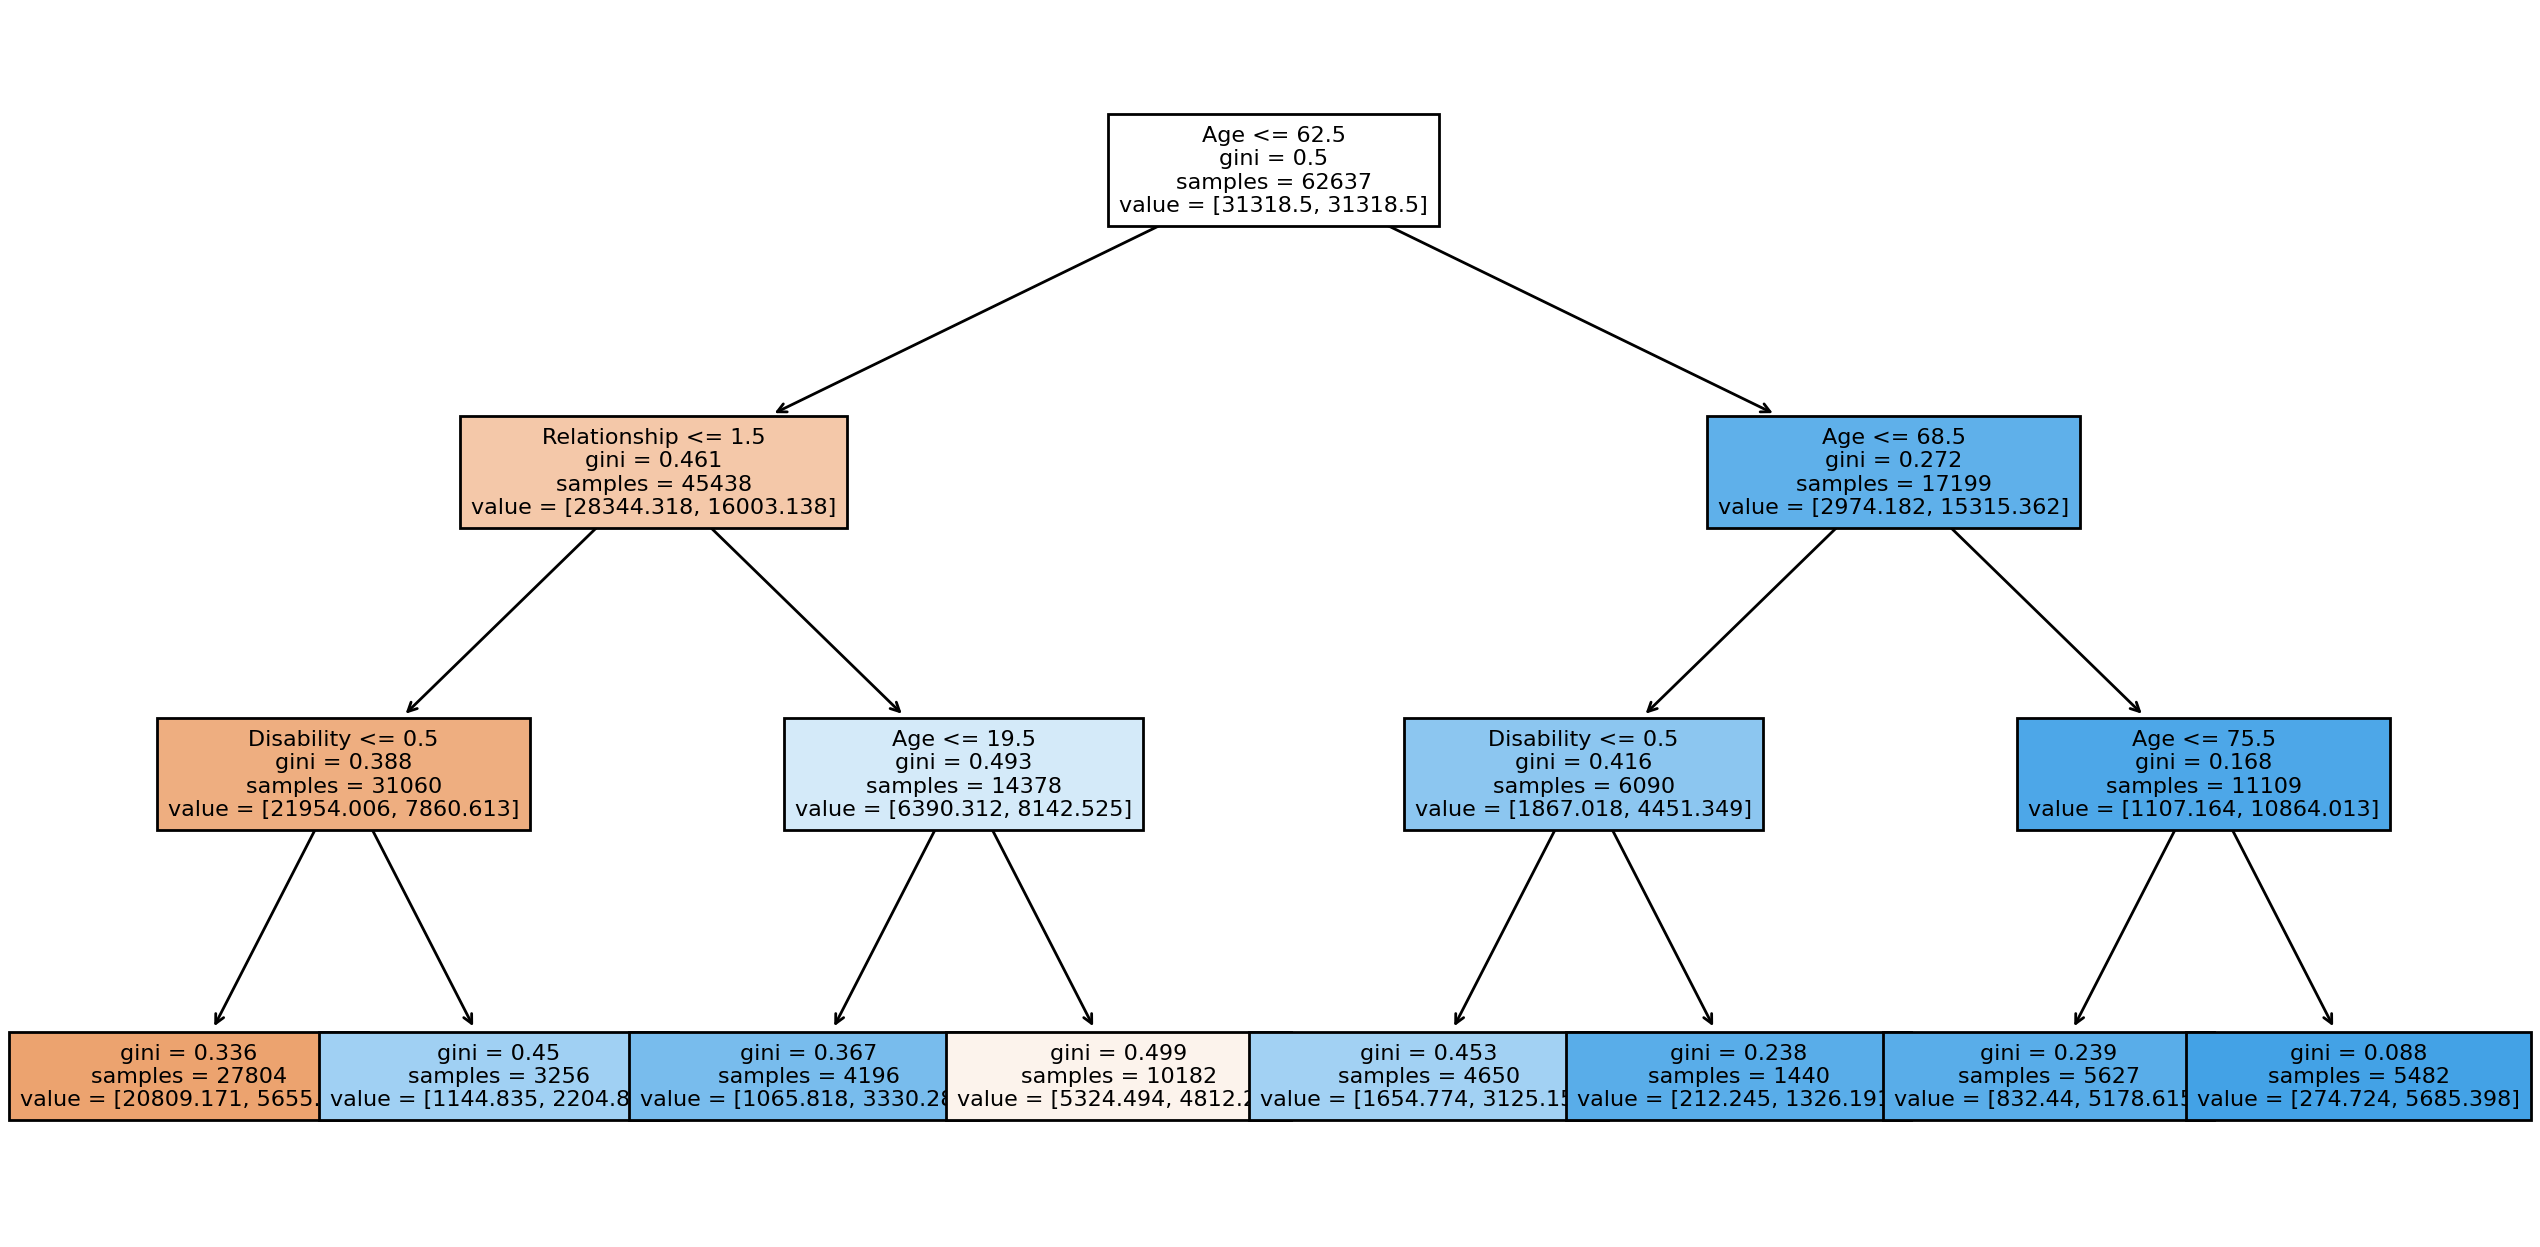

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=200)
tree.plot_tree(class_models['decision_tree']['model'], feature_names=feature_l,\
               filled=True, max_depth=3, fontsize=8)
fig.show()

As you can see, each node has a **gini coefficient**. It can use this to tally the importances of each feature:

In [ ]:
dt_imp_df = pd.DataFrame({'feature':feature_l,\
                        'importance': class_models['decision_tree']['model'].feature_importances_})
dt_imp_df.sort_values(by='importance', ascending=False).style.\
                bar(subset=['importance'], color='#4EF', width=100)

,feature,importance
0,Age,0.693056
3,Relationship,0.176194
4,Disability,0.130750
1,Schooling,0.000000
2,Marital Status,0.000000
5,Employment Status,0.000000
6,Citizen Status,0.000000
7,Mobility Status,0.000000
8,Military Service,0.000000
9,Ancestry,0.000000


It shouldn't surprise you that only three features have importances because the three only uses three of the features!

#### 5.1.3) Fast interpretable greedy-tree sums (FIGS)

This is a new interpretable tree-based model, which is very promising.

![FIGS diagram](https://github.com/smasis001/av-2022/blob/main/FIGS_Figure1.png?raw=1)

> Tan, Y.S., Singh, C., Nasseri, K., Agarwal, A., & Yu, B. (2022). Fast Interpretable Greedy-Tree Sums (FIGS). [ArXiv, abs/2201.11931](https://arxiv.org/abs/2201.11931).

It's more than one tree so to make a single prediction it navigates each tree to arrive to a score for that tree and then adds the score to come up with a final score.

In [ ]:
figs_mdl = class_models['figs']['model']
print(figs_mdl.__str__())

> ------------------------------
> FIGS-Fast Interpretable Greedy-Tree Sums:
> 	Predictions are made by summing the "Val" reached by traversing each tree
> ------------------------------
Age <= 62.500 (Tree #0 root)
	Relationship <= 1.500 (split)
		Sex <= 1.500 (split)
			Val: 0.177 (leaf)
			Val: 0.315 (leaf)
		Age <= 19.500 (split)
			Val: 0.753 (leaf)
			Relationship <= 15.500 (split)
				Val: 0.366 (leaf)
				Military Service <= 1.500 (split)
					Val: -0.003 (leaf)
					Val: 0.740 (leaf)
	Age <= 68.500 (split)
		Val: 0.692 (leaf)
		Val: 0.880 (leaf)

	+
Disability <= 0.500 (Tree #1 root)
	Val: -0.048 (leaf)
	Age <= 62.500 (split)
		Age <= 34.500 (split)
			Val: 0.144 (leaf)
			Val: 0.376 (leaf)
		Val: 0.112 (leaf)

	+
Schooling <= 19.500 (Tree #2 root)
	Val: 0.023 (leaf)
	Val: -0.070 (leaf)



This can be easily read by splitting on feature values on every branch. You can even extract "rules" from traversing every tree till each leave and then the models' rules are the cardinal product of every trees' rules.

#### 5.1.4) Explainable Boosting Machines

EBM leverages the Generalized Additive Models (GAM)s, and incorporates bagging and gradient boosting much like Catboost and XGBooost does.

> Lou, Y., Caruana, R., Gehrke, J., & Hooker, G. (2013). Accurate intelligible models with pairwise interactions. Proceedings of the 19th ACM SIGKDD international conference on Knowledge discovery and data mining. [DOI:10.1145/2487575.2487579](https://dl.acm.org/doi/10.1145/2487575.2487579)

In [ ]:
ebm_mdl = class_models['ebm']['model']
ebm_explanation = ebm_mdl.explain_global()

ebm_imp_df = pd.DataFrame({'feature':ebm_explanation._internal_obj['overall']['names'],\
                        'importance':ebm_explanation._internal_obj['overall']['scores']})
ebm_imp_df.sort_values(by='importance', ascending=False).style.\
                bar(subset=['importance'], color='#4EF', width=100)

,feature,importance
0,Age,1.102083
4,Disability,0.440297
3,Relationship,0.410496
14,Sex,0.296237
1,Schooling,0.280809
16,Marital Status x Sex,0.222436
18,Age x Sex,0.125949
8,Military Service,0.108839
25,Age x Schooling,0.094380
21,Age x Disability,0.091876


So what to do with **Catboost**, and **MLP**?

### 5.2) Model-agnostic (treats the model as a "black box")
#### _also known as post-hoc interpretability_

#### 5.2.1) Global Explanations with SHAP

Creating a SHAP explainer is simple:

In [ ]:
%%time
cb_mdl = class_models['catboost']['model']
cb_explainer = shap.Explainer(cb_mdl)
cb_shap = cb_explainer(X_test)

CPU times: user 1.99 s, sys: 33.3 ms, total: 2.03 s
Wall time: 1.18 s


We can verify it's the right explainer like this:

In [ ]:
print(type(cb_explainer))

<class 'shap.explainers._tree.Tree'>


> **IMPORTANT NOTE**: Tree SHAP explainers are technically not model-agnostic but the SHAP library includes methods for most models, including some model-agnostic ones like Kernel Explainer.

We can do the same with MLP except since it uses the Kernel Explainer it takes much longer: 

In [ ]:
%%time
mlp_mdl = class_models['mlp']['model']
mlp_explainer = shap.KernelExplainer(mlp_mdl.predict, shap.kmeans(X_train, 20))

#takes long
# mlp_shap_vals = mlp_explainer.shap_values(X_test.sample(frac=.05))

CPU times: user 6.27 s, sys: 7.1 s, total: 13.4 s
Wall time: 6.74 s


In [ ]:
print(type(mlp_explainer))

<class 'shap.explainers._kernel.Kernel'>


In any case, the SHAP object will return data and values of equal dimensions:

In [ ]:
print("Values dimensions: %s" % (cb_shap.values.shape,)) 
print("Data dimensions:   %s" % (cb_shap.data.shape,))

Values dimensions: (20880, 16)
Data dimensions:   (20880, 16)


one SHAP value per each feature-observation datapoint.

So, what can we do with SHAP? For starters...

**Bar chart with feature importance**

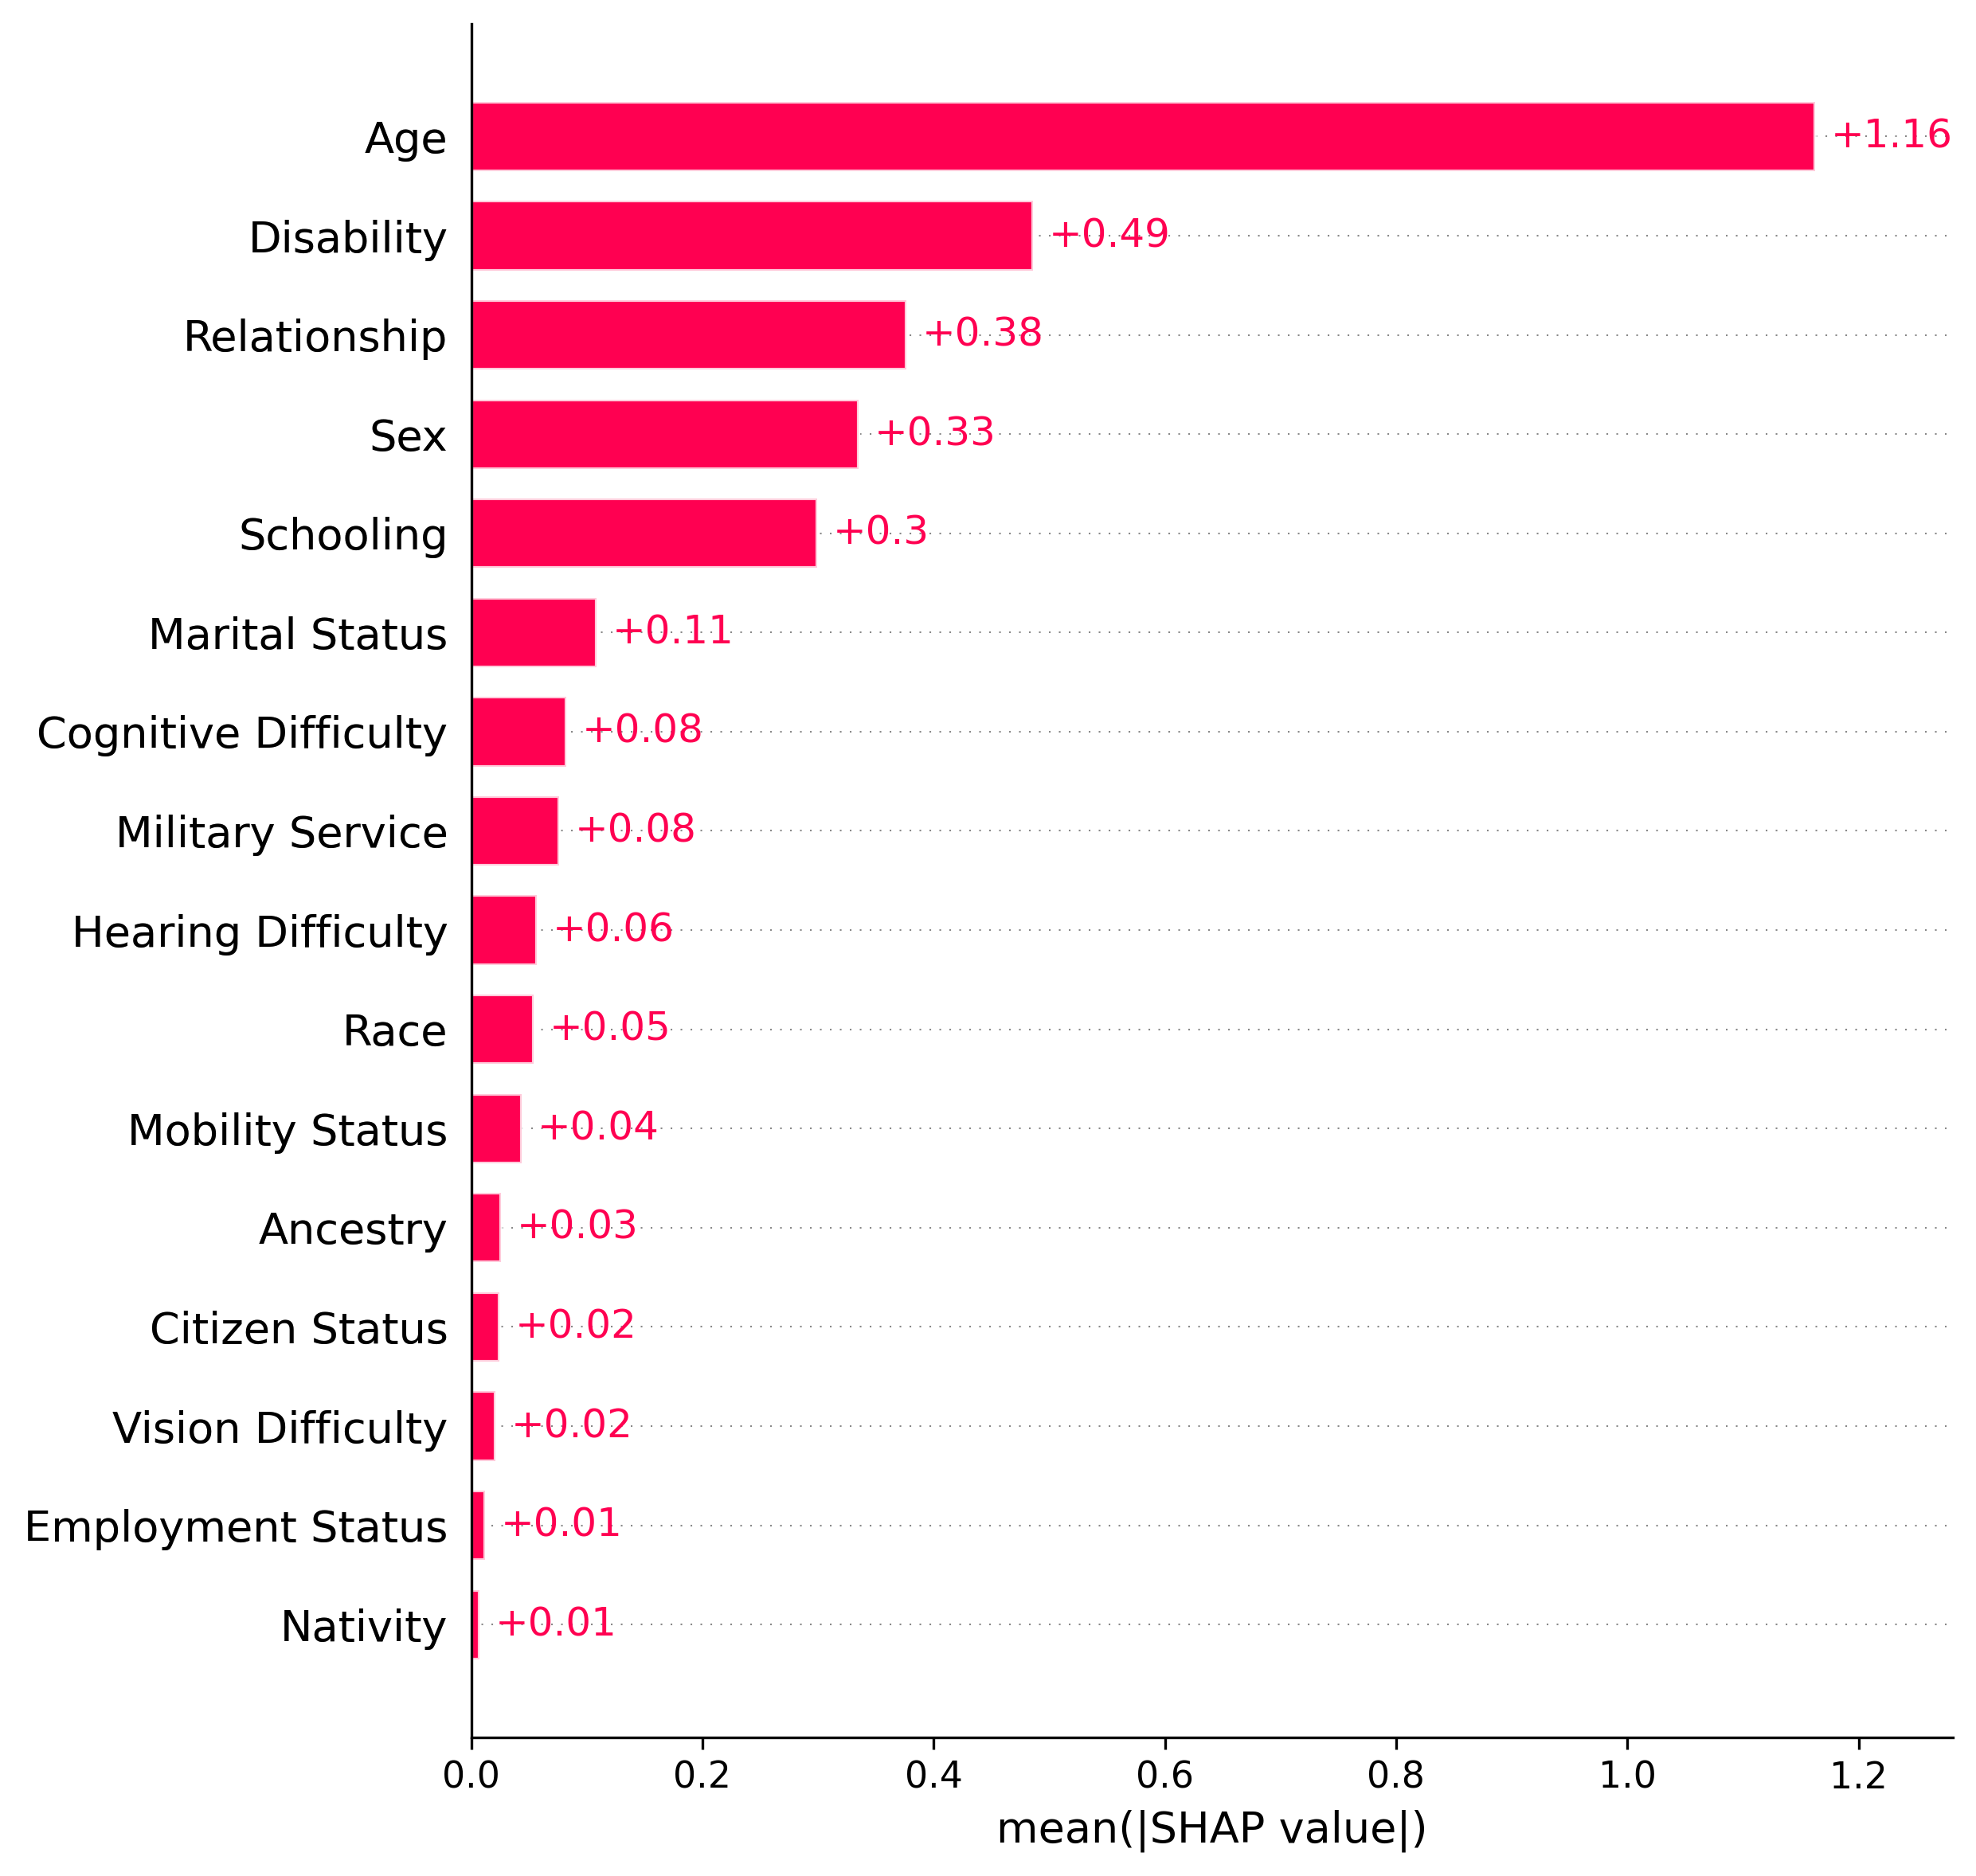

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
shap.plots.bar(cb_shap, max_display=17, show=False)
plt.show()

**Bar chart with feature importance (split by cohorts)**

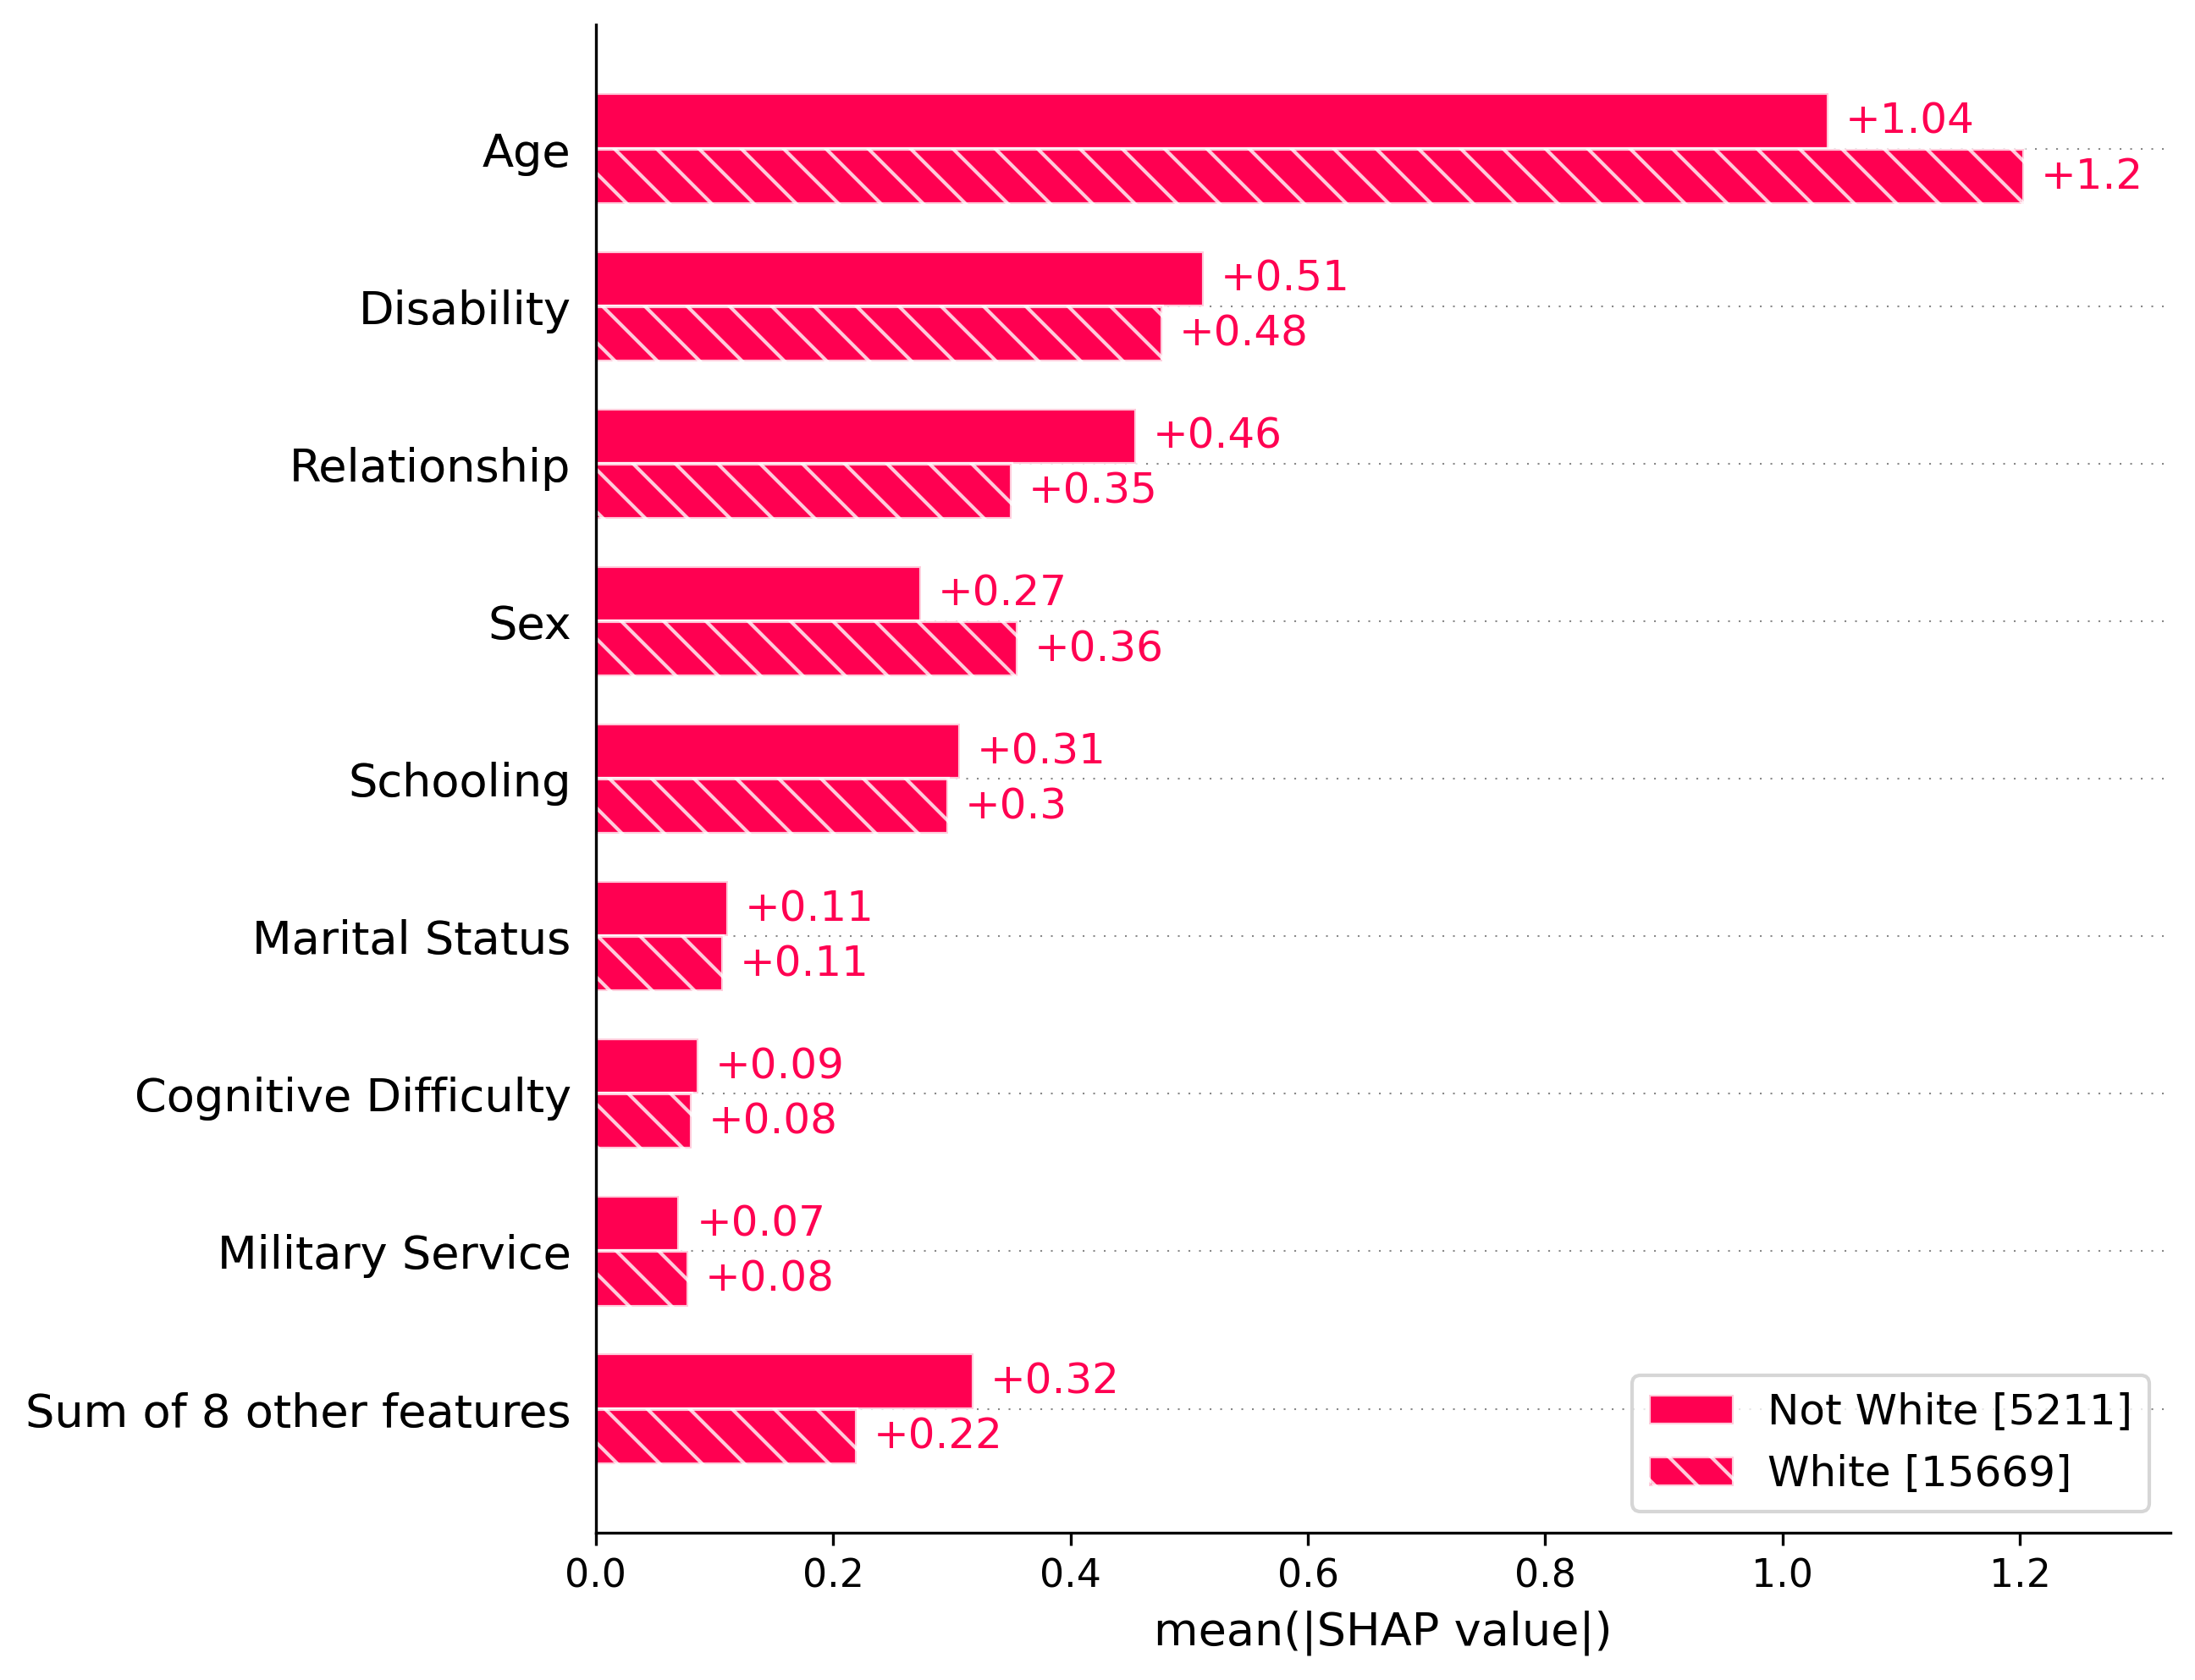

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
race_cohort = np.where(X_test.Race == 1, "White", "Not White")
shap.plots.bar(cb_shap.cohorts(race_cohort).abs.mean(0), max_display=9,\
               show=False)
plt.show()

**Beeswarm plot**

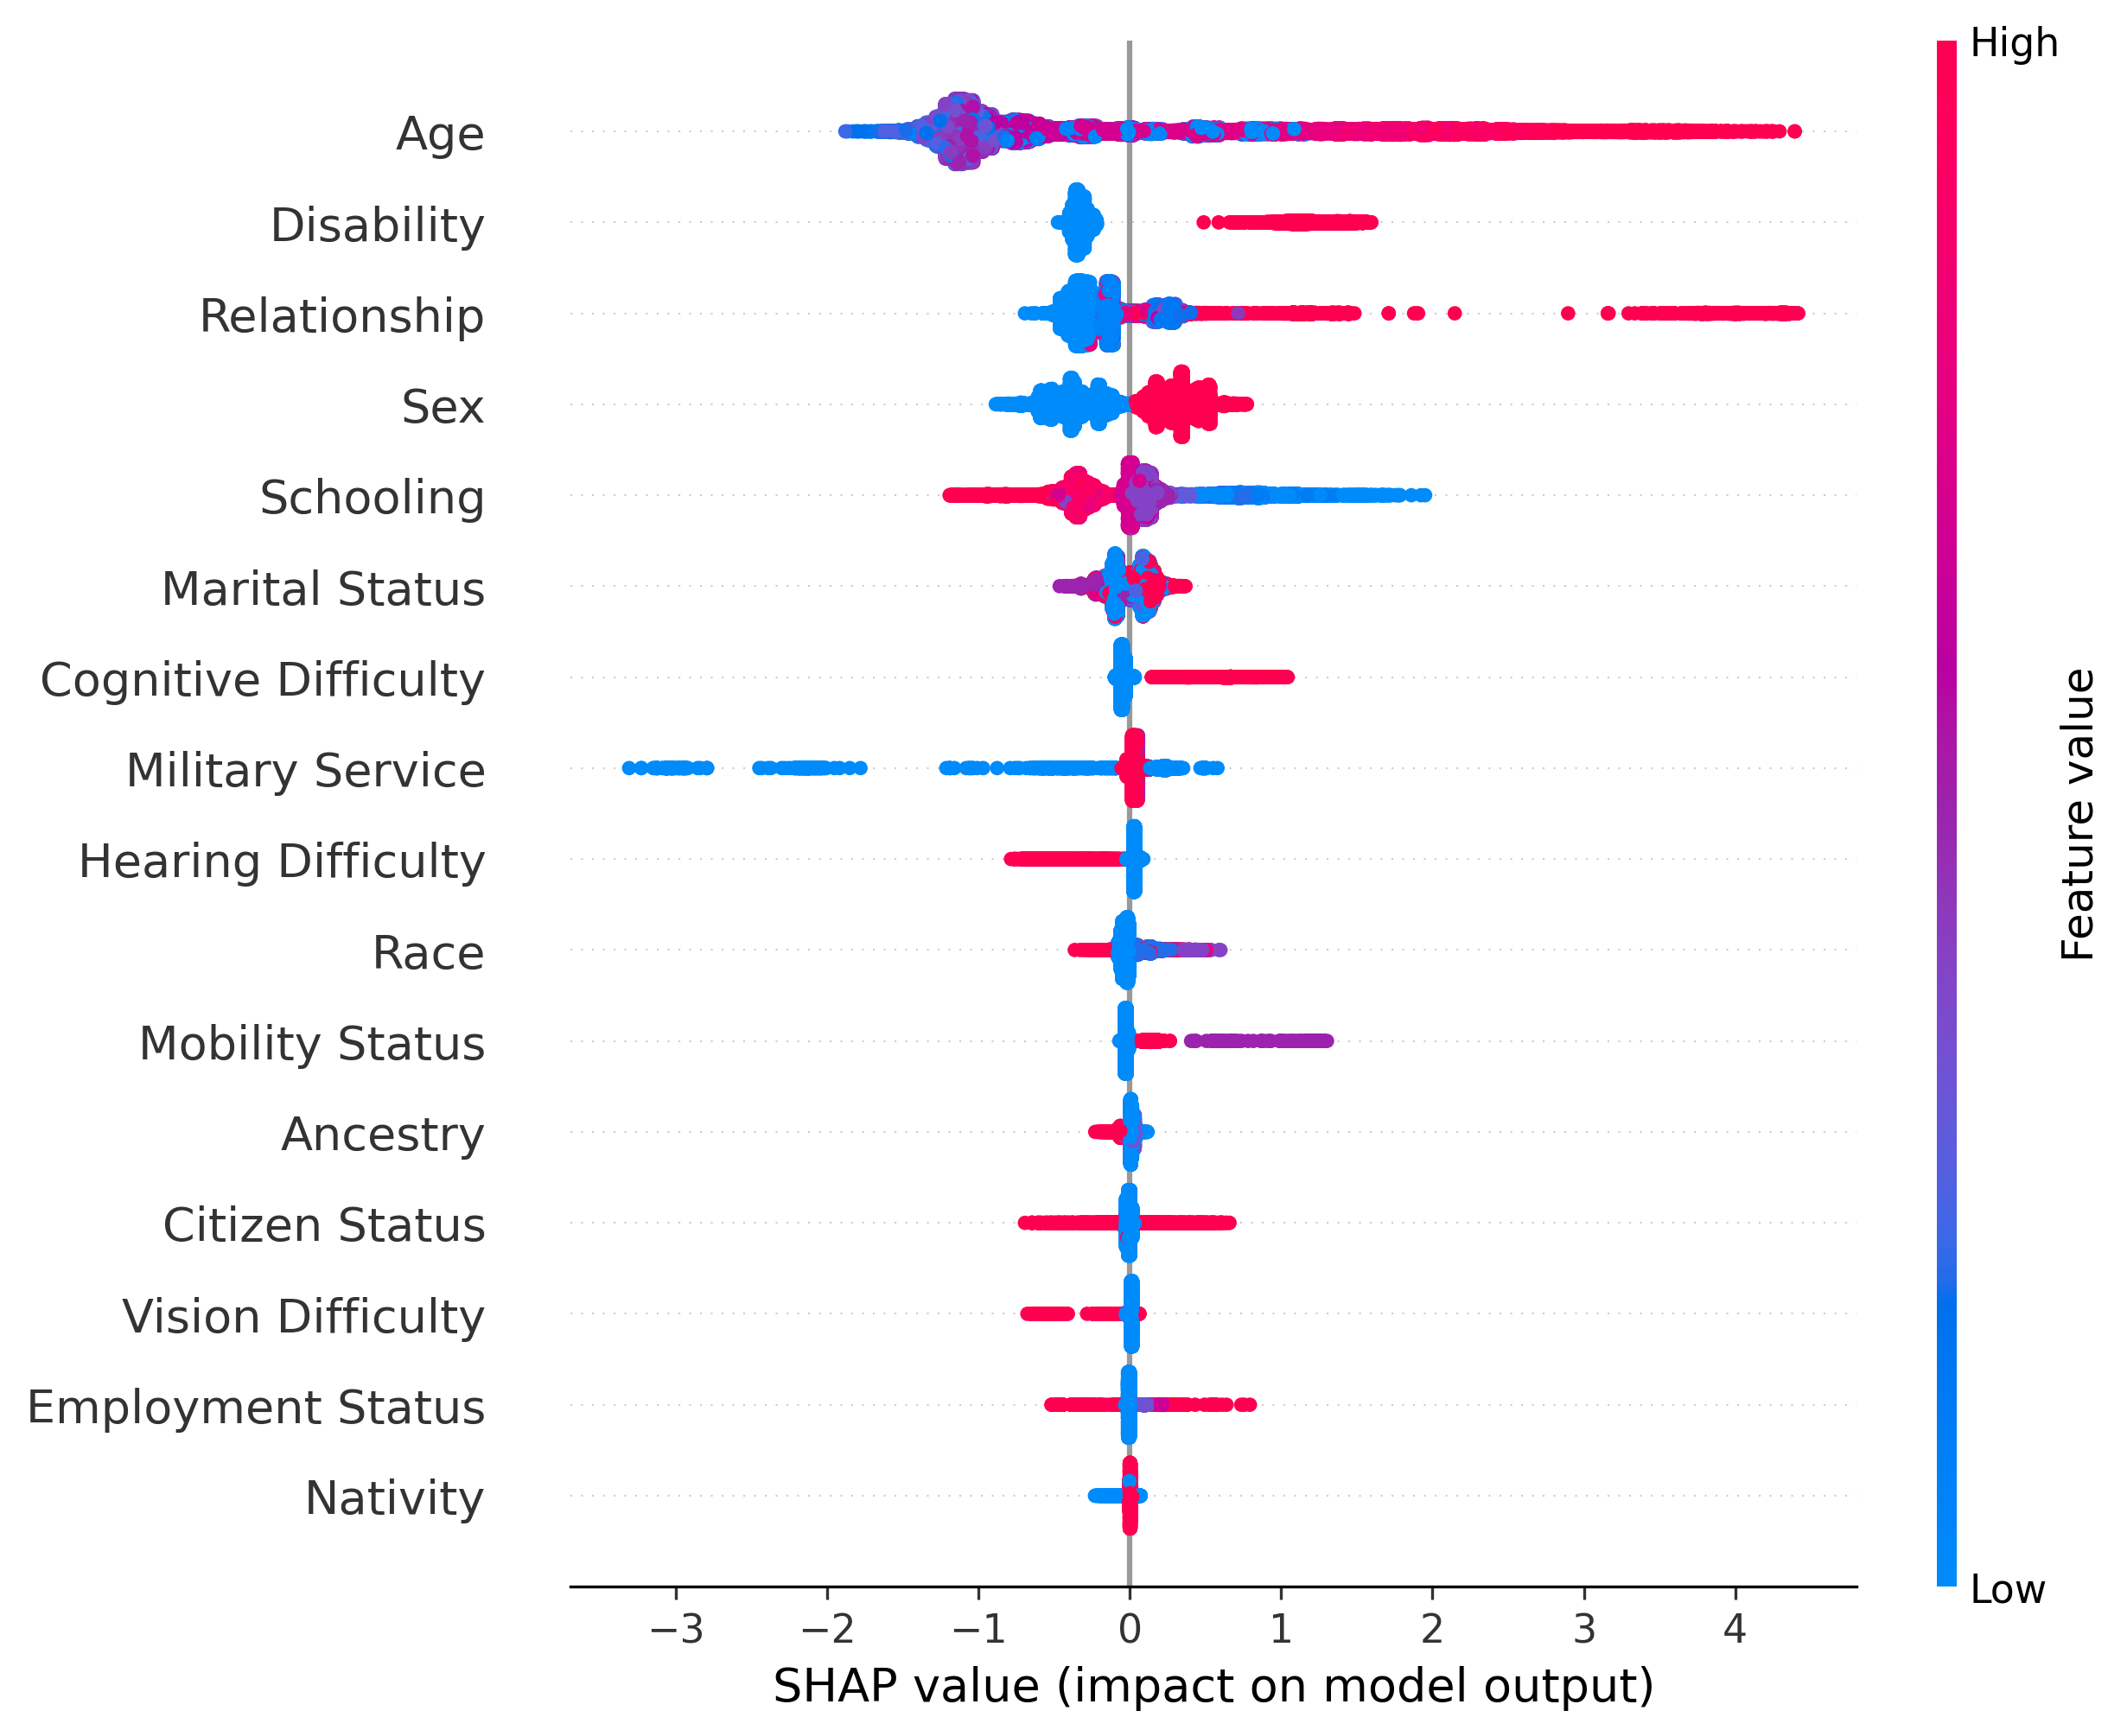

In [ ]:
plt.figure(figsize=(8, 8), dpi=300)
shap.plots.beeswarm(cb_shap, max_display=17, show=False)
plt.show()

#### 5.2.2) Feature Summary Explanations

**Partial dependence plots**

Partial dependence plots show the marginal effect a feature has on the predicted outcome throughout all the potential values of said feature.

What we are asking here, is what is the average predicted outcome for each observation should we change it's `Age`

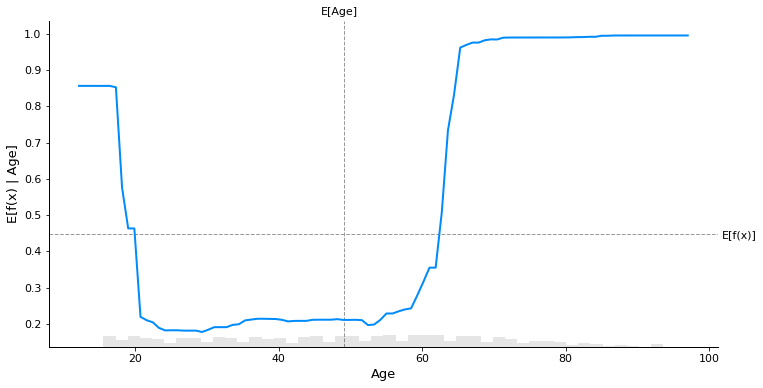

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
shap.plots.partial_dependence("Age", cb_mdl.predict, X_test,\
                              ice=False, model_expected_value=True, feature_expected_value=True,\
                              show=False)
plt.show()

As you can see in the previous plot, when the age is under 21 and over 64 the probability of "Not Working" is above average and shoots up under and above these ages. This is to be expected.

**SHAP scatter plot**

The SHAP scatter plot can show something similar but instead of averaging out the predictions for all possible values for a features, it uses the SHAP values which are, themselves, indicative of how much a feature impacts the outcome.

One of the advantages of the scatter plot is you can color code the dots with the SHAP value for another feature.

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: htt

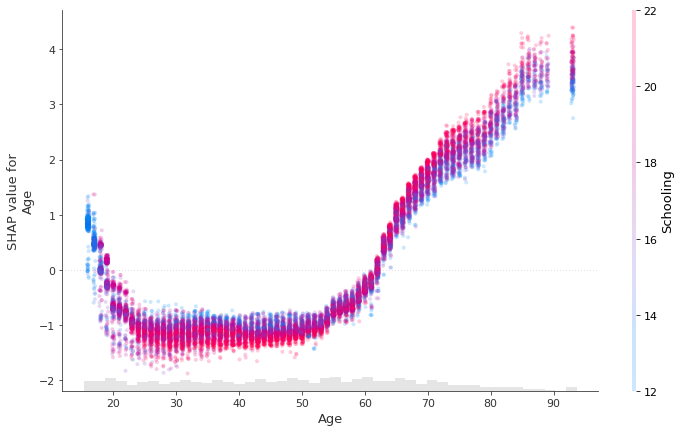

In [ ]:
shap.plots.scatter(cb_shap[:,"Age"], color=cb_shap[:,"Schooling"],\
                   show=False, alpha=0.2, x_jitter=0.4)
plt.gcf().set_size_inches(12, 7)
plt.show()

#### 5.2.3) Feature Interactions

In [ ]:
%%time
clustering = shap.utils.hclust(X, y)

17it [02:06,  7.93s/it]                        

CPU times: user 4min 33s, sys: 0 ns, total: 4min 33s
Wall time: 2min 18s


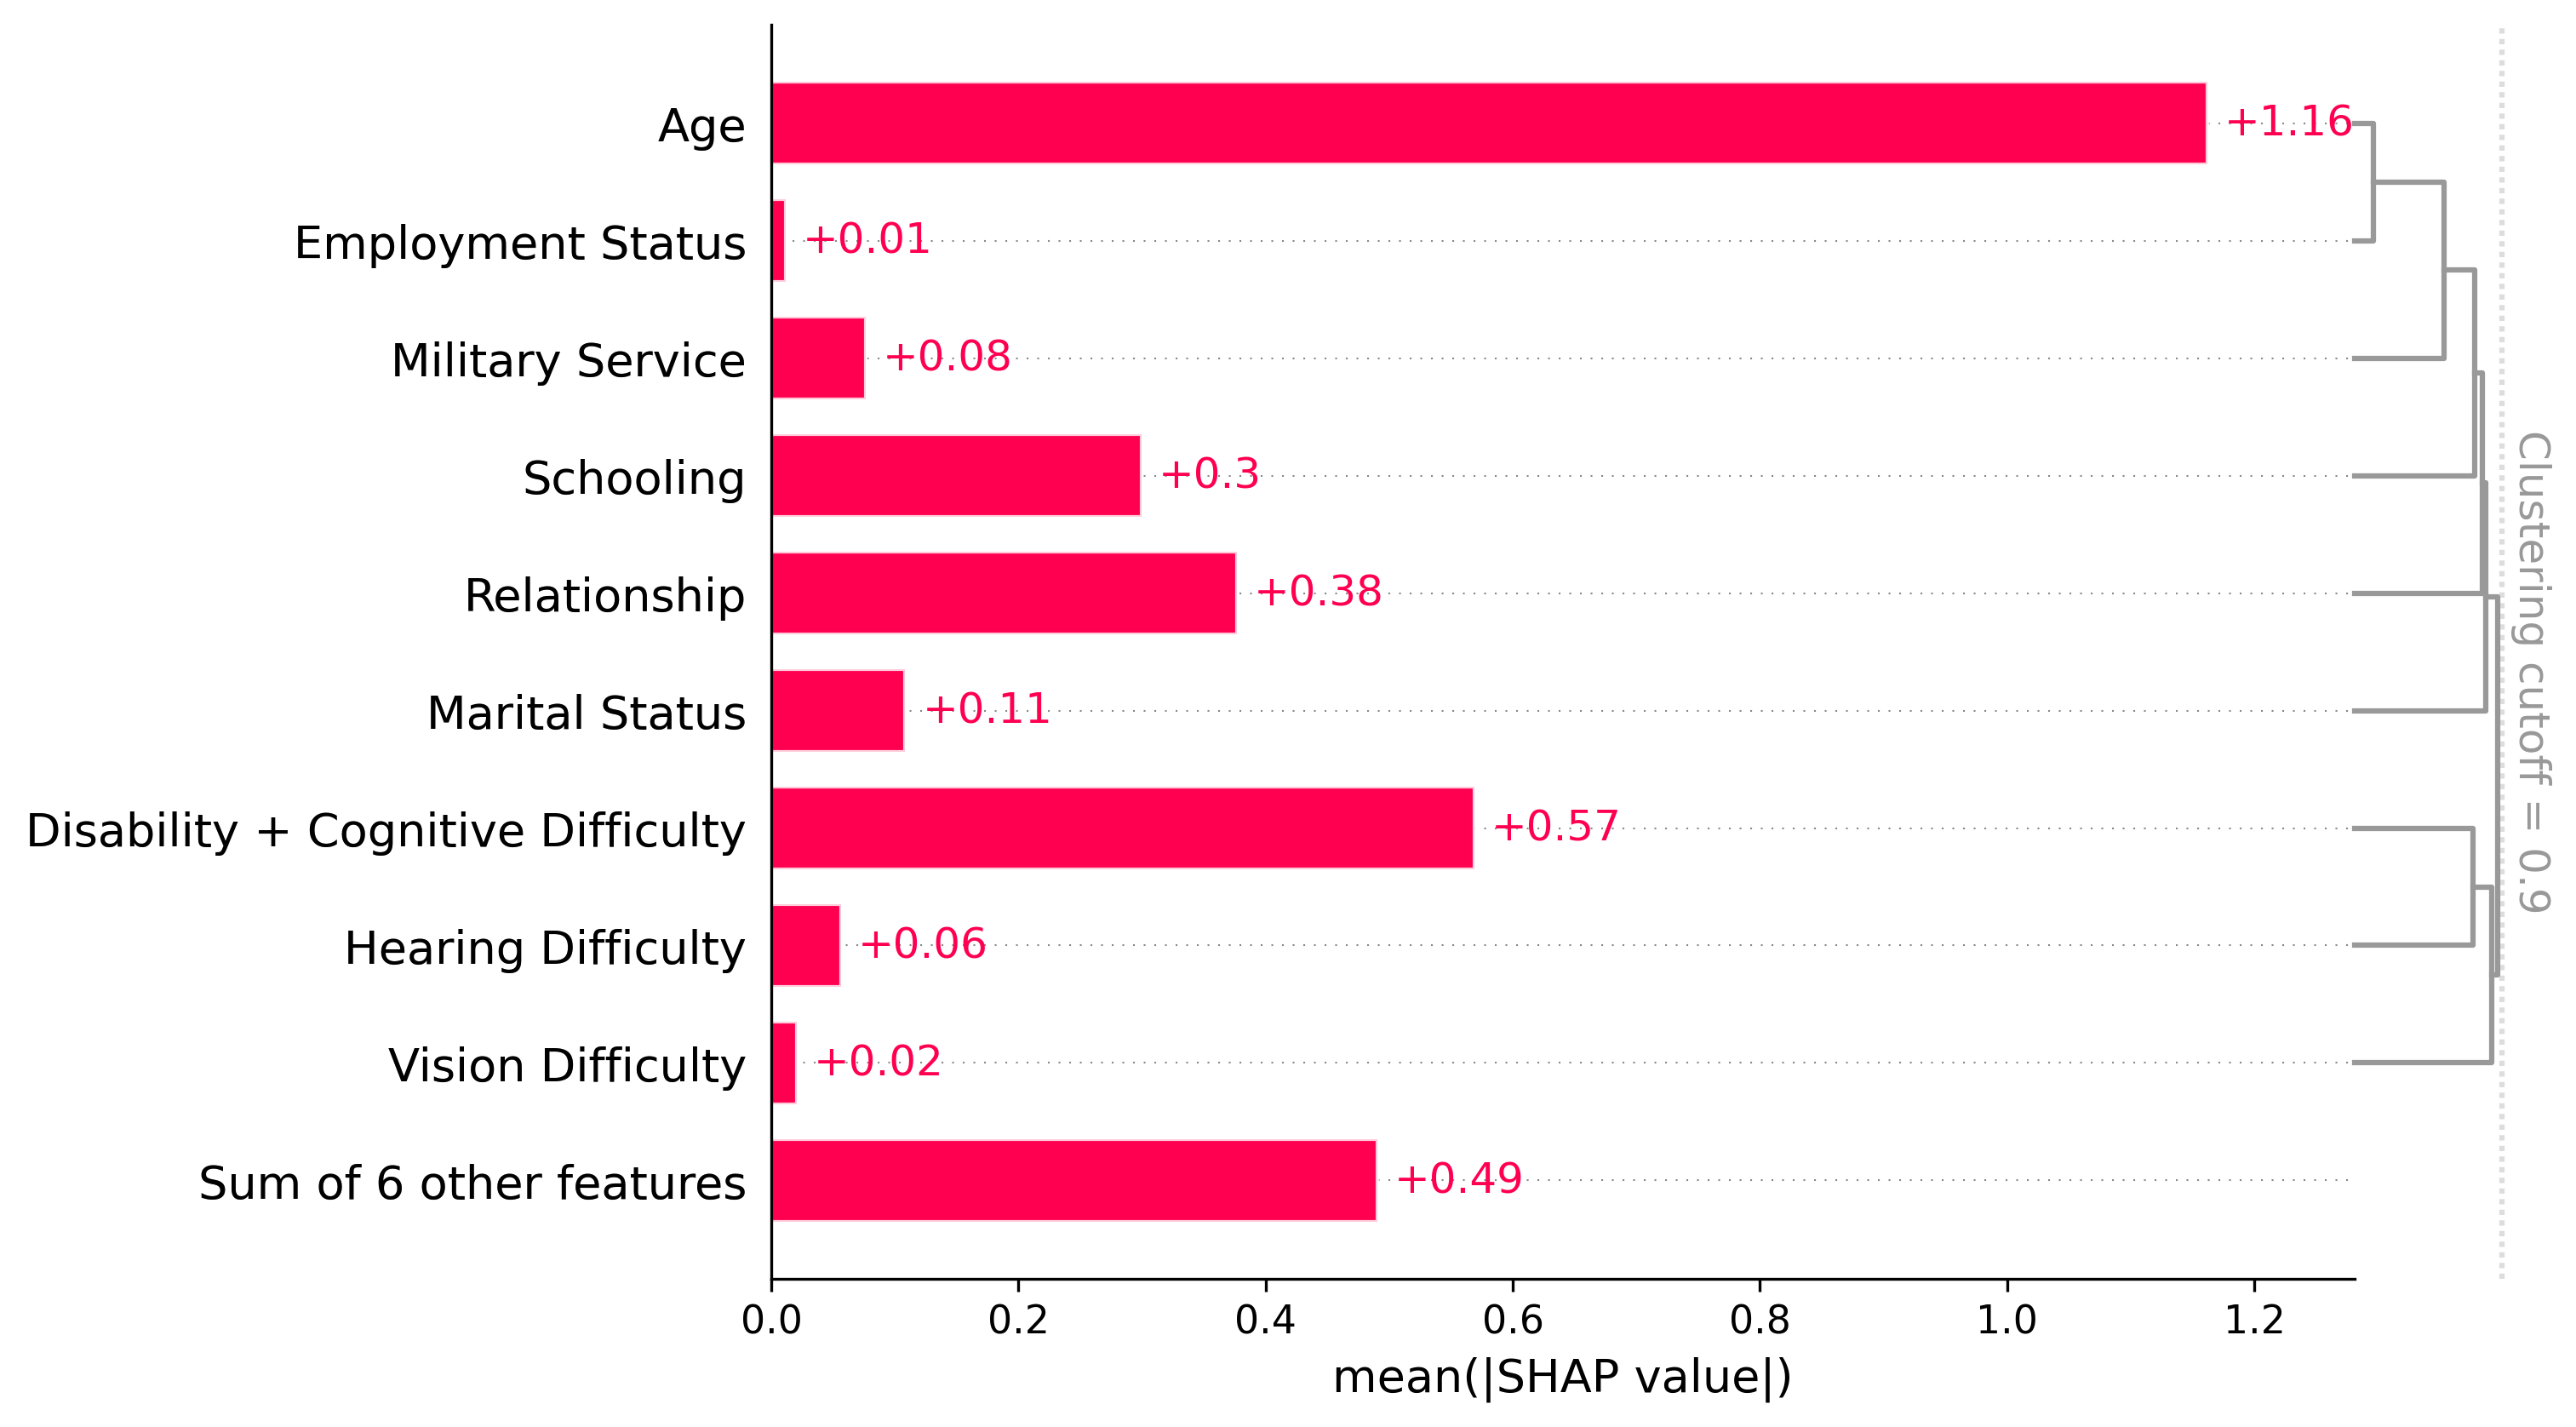

In [ ]:
plt.figure(figsize=(12, 12), dpi=300)
shap.plots.bar(cb_shap, clustering=clustering, clustering_cutoff=0.9,\
               show=False)
plt.show()

The above feature importance plot is **clustered** by features that have interaction effects. The **dendogram** to the right shows which features are directly and indirectly connected with the lines.

#### 5.2.4) Local Explanations

**SHAP Bar plot**

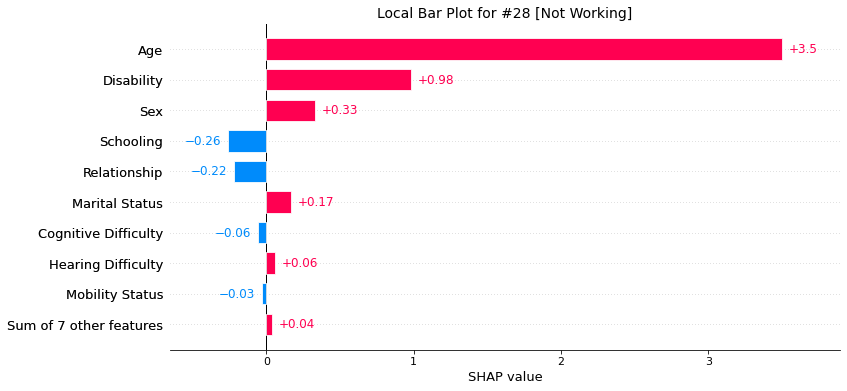

In [ ]:
shap.plots.bar(cb_shap[28], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Bar Plot for #28 [Not Working]', fontsize=14)
plt.show()

**SHAP waterfall plot**

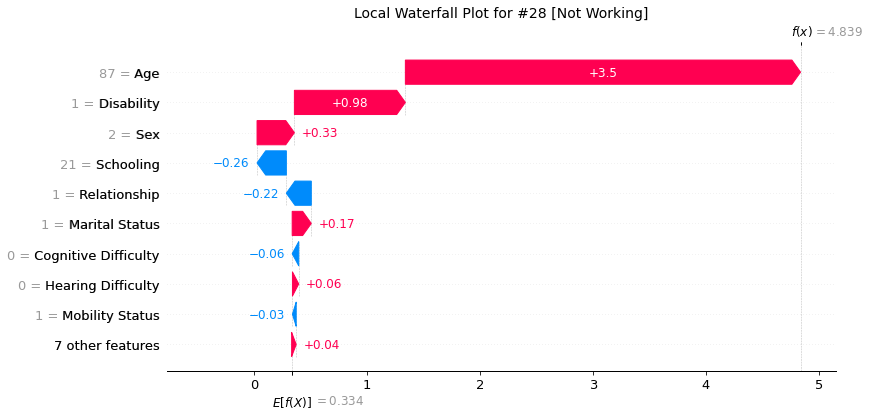

In [ ]:
shap.plots.waterfall(cb_shap[28], show=False)
plt.gcf().set_size_inches(12, 6)
plt.title('Local Waterfall Plot for #28 [Not Working]', fontsize=14)
plt.show()

**SHAP force plot**

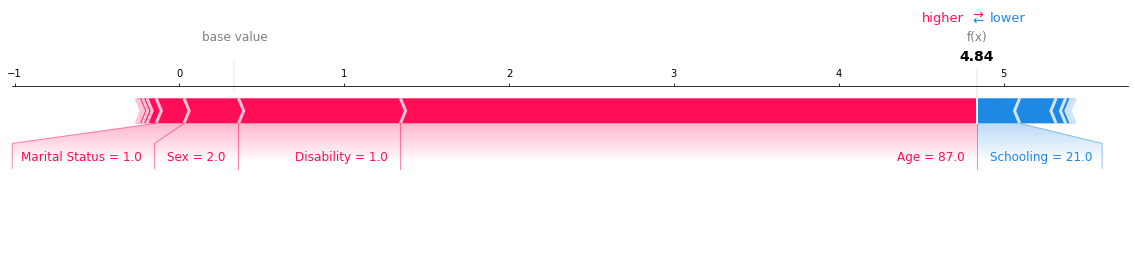

In [ ]:
shap.plots.force(cb_shap[28], matplotlib=True)

**SHAP decision plots**

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


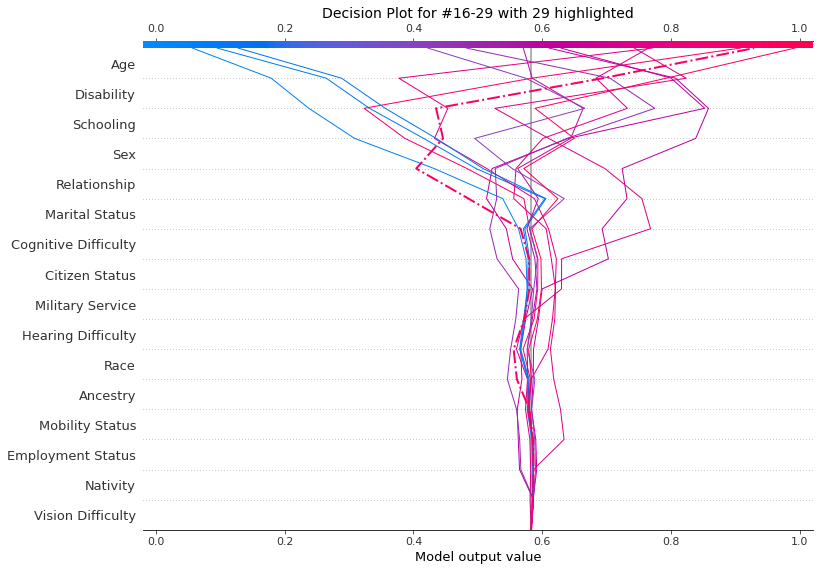

In [ ]:
shap.decision_plot(cb_explainer.expected_value, cb_shap.values[16:30], X_test.iloc[16:30], highlight=13,\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #16-29 with 29 highlighted', fontsize=14)
plt.show()

`np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


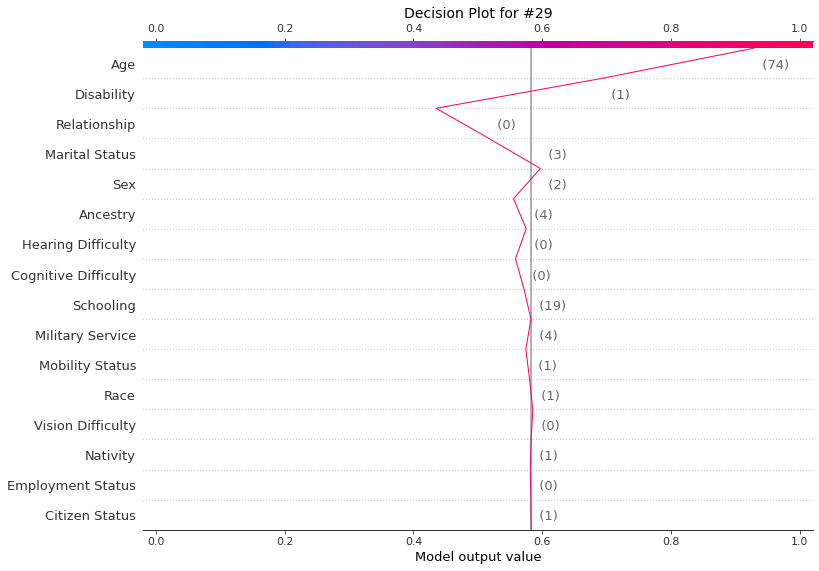

In [ ]:
shap.decision_plot(cb_explainer.expected_value, cb_shap.values[29], X_test.iloc[29],\
                   show=False, link='logit')
plt.gcf().set_size_inches(12, 9)
plt.title('Decision Plot for #29', fontsize=14)
plt.show()